# Perturbation Methods in Finance

Consider the corresponding Black-Scholes partial differential equation to price the
European put option $P(S,t)$:
$$
 \frac{\partial P}{\partial t} + \frac12 \sigma ^2S^2\frac{\partial^2 P}{\partial S^2} + rS\frac{\partial P}{\partial S} - rP = 0
$$
subject to the boundary conditions:
$$P (S, t = T ) = \max(X-S, 0),$$
$$P (0, t) = Xe^{-r(T-t)} ,$$
$$P (S, t) \rightarrow 0 \text{ as } S \rightarrow \infty.$$
where, by convention, $S$ is the value of the underlying asset, $X$ is the strike price of the put
option, $\sigma$ is the volatility, $r$ is the risk-free rate and $t$ is time. Here $\sigma$ is typically in the 0.2-0.4 value range, which leads to the squared volatility being quite small. Now since $\sigma^2$ multiplies the highest derivative we have singular perturbation problem.

Apply a scaling such that the new variables $\tau$, $\hat S$, and $\hat P$, all of constant order (i.e., $O(1)$)
$$
\tau = T-t,$$
$$
\hat S = \frac{S - Xe^{-r(T-t)} }{\sigma},$$
$$\hat P ( \hat S, \tau) = \frac{P(S,t)}{\sigma}.$$
where $\sigma$ is supposed to be small. Under this transformation we can write a regular asymptotic expansion 
$$
\hat P ( \hat S, \tau) = \hat P_0( \hat S, \tau) + \sigma \hat P_1( \hat S, \tau) + \sigma^2 \hat P_2( \hat S, \tau) + \dots
$$
and at leading order $O(\sigma)$ we have
$$
-\frac{\partial \hat P_0}{\partial \tau} + \frac12 \left(Xe^{-r\tau}\right)^2\frac{\partial^2 \hat P_0}{\partial \hat S^2} +r\hat S \frac{\partial \hat P_0}{\partial \hat S} - rP_0 = 0
$$
and at the next $O(\sigma^2)$ equation is
$$
-\frac{\partial \hat P_1}{\partial \tau} + \frac12 \left(Xe^{-r\tau}\right)^2\frac{\partial^2 \hat P_1}{\partial \hat S^2} +r\hat S \frac{\partial \hat P_1}{\partial \hat S}- rP_1 = -SXe^{r\tau}\frac{\partial^2 \hat P_0}{\partial \hat S^2}.
$$
In general for $O(\sigma^{n+1})$ and $n\geq 2$ we can write
$$
-\frac{\partial \hat P_n}{\partial \tau} + \frac12 \left(Xe^{-r\tau}\right)^2\frac{\partial^2 \hat P_n}{\partial \hat S^2} +r\hat S \frac{\partial \hat P_n}{\partial \hat S}- rP_n = -SXe^{r\tau}\frac{\partial^2 \hat P_{n-1}}{\partial \hat S^2} + \frac12 \hat S^2 \frac{\partial^2 \hat P_{n-2}}{\partial \hat S^2}.
$$

The boundary conditions for the problem are given at $n=0$ by
$$
\hat P_0(\hat S,\tau=0) = \max(-\hat S,0),
$$
$$
\hat P_0 \rightarrow 0 \text{ as } \hat S \rightarrow \infty,
$$
$$
\frac{\partial \hat P_0}{\partial \hat S} \rightarrow -1 \text{ as } \hat S \rightarrow -\infty,
$$
and for $n\geq 1$ we solve according to
$$
\hat P_n(\hat S,\tau=0) = 0,
$$
$$
\hat P_n \rightarrow 0 \text{ as } \hat S \rightarrow \infty,
$$
$$
\hat P_n \rightarrow 0 \text{ as } \hat S \rightarrow -\infty .$$

Now for the coding. Add in some libraries for plotting, as well as a tridiagonal solver and lagrange interpolator, both needed here.

In [1]:
#include "msc_project_perturbationMethods.hpp"

First we solve for $P_0$, showing how the solution is formed and then transformed back to the original variables. Declare some required variables:

In [2]:
double T=1.; // contract maturity date
double r=0.03; // risk free interest rate
double X=1.; // strike price
// declare and initialise grid paramaters 
int iMax=100; // number of time steps
int jMax=100; // number of space steps

// declare and initialise local grid variables (dlambda,dt)
double sHat_min=-5*X;
double sHat_max=5*X;
double dS=(sHat_max-sHat_min)/jMax;
double dt=T/iMax;

std::vector<double> sHat(jMax+1);
std::vector<double> P0(jMax+1);

Initialise values with the boundary condition.

In [3]:
for(int j=0;j<=jMax;j++)
    sHat[j] = sHat_min + j*dS;
// setup and initialise the final conditions on the option price 
// for n=0 we have P_0 = max(-\hat S,0) 
for(int j=0;j<=jMax;j++)
    P0[j] = std::max(-sHat[j],0.);

Now solve backwards in time using a Crank-Nicolson finite difference scheme

In [4]:
for(int i=iMax-1;i>=0;i--)
{
    double tau=T-(i+0.5)*dt;
    // declare vectors for matrix equations
    std::vector<double> a(jMax+1),b(jMax+1),c(jMax+1),d(jMax+1);
    
    // O(sigma) equation
    
    // set up matrix equations for the boundary at lambda=0
    a[0]=0.;b[0]=-1/dS;c[0]=1./dS;d[0] = -1.;
    // set up the scheme in the middle
    for(int j=1;j<=jMax-1;j++)
    {
      a[j]=0.25*X*X*exp(-2.*r*tau)/dS/dS-0.25*r*sHat[j]/dS;
      b[j]=-0.5*X*X*exp(-2.*r*tau)/dS/dS - 0.5*r - 1./dt;
      c[j]=0.25*X*X*exp(-2.*r*tau)/dS/dS+0.25*r*sHat[j]/dS;
      d[j]=-a[j]*P0[j-1]-(b[j]+2./dt)*P0[j]-c[j]*P0[j+1];
    }
    // set up boundary at lambda_max
    a[jMax]=0.;b[jMax]=1.;c[jMax]=0.;d[jMax] = 0.;
    // solve the system of equations with Thomas algorithm
    // note that "d" contains the solution on exit
    MATH60082::thomasSolve(a,b,c,d);
    P0=d;
}

Now we can plot out the solution for $\hat P_0(\hat S,\tau=T)$ against $\hat S$, which should look something like this:

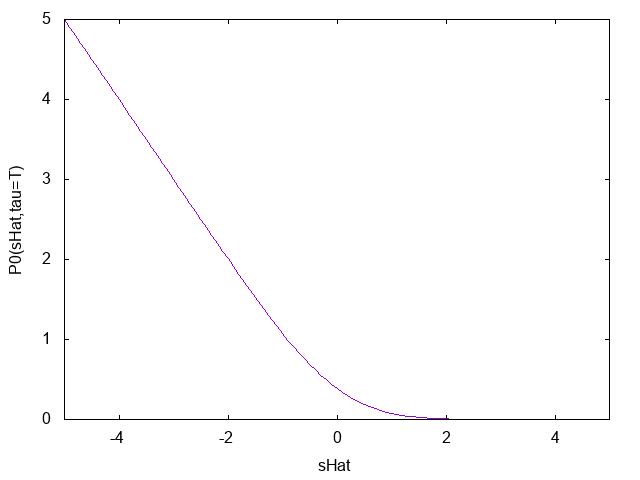

In [5]:
{
    std::stringstream ss("set xrange [-5:5]\n"
                        "set xlabel \"sHat\"\n"
                        "set ylabel \"P0(sHat,tau=T)\"\n");
    figure = G.plotData(sHat,P0,&ss);
}
figure

Now what we really want is the option value in the original variables, so to do this we need to calculate the value of $\hat S$ for a given $S_0$. Consider the case with $S_0=0.965$, and choosing some small value $\sigma=0.1$, we can calculate
$$
\hat S_0 = \frac{S_0-Xe^{-rT}}{\sigma} = -0.054455335
$$
so
$$
P(S=0.965,t=0) = \sigma \hat P_0(\hat S = -0.054455335,\tau=T)
$$

In [6]:
double S0=0.965; // initial stock price
double sigma=0.1; // value of sigma

// calculate value of sHat
double sHat0 = (S0-X*exp(-r*T))/sigma;

// apply perturbation expansion
std::cout << "P(S="<<S0<<") = " << sigma*MATH60082::lagrangeInterpolation(P0,sHat,sHat0) << std::endl;

P(S=0.965) = 0.0414493


The analytic value of the option should be $P(S,t)=0.04137427$ so we can see that our approximation is not too far away.

We can now write this in a handy function to calculate the result, noting that if you are outside the shear layer you should use the outer solution.

In [7]:
double getOptionValue(const std::vector<double> &sHat,
		      const std::vector<double>& P0,
		      double S0, // initial stock value
		      double T, // contract maturity date
		      double X, // risk free interest rate
		      double r, // risk free interest rate
		      double sigma // volatility of default rate
)
{
  // finish looping through time levels
  // return the interpolated value at lambda0
  double sHat0 = (S0-X*exp(-r*T))/sigma;
  // 
  if(sHat0 > sHat[sHat.size()-1])
      return 0.;
  else if(sHat0 < sHat.front())
      return X*exp(-r*T)-S0;
  else
      return sigma*MATH60082::lagrangeInterpolation(P0,sHat,sHat0);
} 

Now use this 

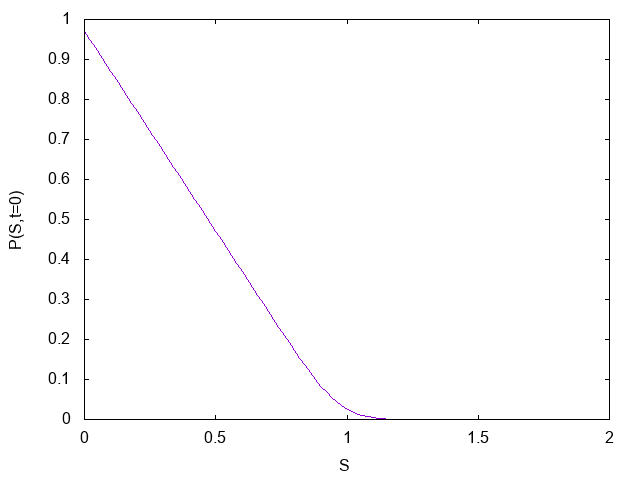

In [8]:
int plotPoints=100;
double SMAX = 2*X;
std::vector<double> stockPrice(plotPoints+1);
std::vector<double> optionValues(plotPoints+1);
  for(int i=0;i<=plotPoints;i++)
  {
      double ds = SMAX/plotPoints;
      stockPrice[i] = i*ds;
      optionValues[i] = getOptionValue(sHat,P0,stockPrice[i],T,X,r,sigma);  
  }
  {
    std::stringstream ss("set xrange [0:2]\n"
                        "set xlabel \"S\"\n"
                        "set ylabel \"P(S,t=0)\"\n");
    figure = G.plotData(stockPrice,optionValues,&ss);
}
figure

# The (n+1)th term Expansion

Now we move onto the $(n+1)$th term expansion. For this we need a variable that stores the value of $P_i$ for $0\leq i \leq n$. Therefore declare this value variable as



In [9]:
int n=1;// for two terms, n=1

std::vector<std::vector<double>> vNew(n+1,std::vector<double>(jMax+1));

Initialise parameters

In [10]:
// setup and initialise the final conditions on the option price 
// for ni=0 we have P_0 = max(-\hat S,0) 
for(int j=0;j<=jMax;j++)
{
    vNew[0][j] = std::max(-sHat[j],0.);
}
// for ni>0 we have P_ni = 0
for(int ni=1;ni<=n;ni++)
{
    for(int j=0;j<=jMax;j++)
    {
        vNew[ni][j] = 0.;
    }
}
  

Step backwards through time

In [11]:
for(int i=iMax-1;i>=0;i--)
{
    std::vector<std::vector<double>> vOld = vNew;
    
    double tau=T-(i+0.5)*dt;
    // declare vectors for matrix equations
    std::vector<double> a(jMax+1),b(jMax+1),c(jMax+1),d(jMax+1);
    
    // O(sigma) equation
    
    // set up matrix equations for the boundary at lambda=0
    a[0]=0.;b[0]=-1/dS;c[0]=1./dS;d[0] = -1.;
    // set up the scheme in the middle
    for(int j=1;j<=jMax-1;j++)
    {
      a[j]=0.25*X*X*exp(-2.*r*tau)/dS/dS-0.25*r*sHat[j]/dS;
      b[j]=-0.5*X*X*exp(-2.*r*tau)/dS/dS - 0.5*r - 1./dt;
      c[j]=0.25*X*X*exp(-2.*r*tau)/dS/dS+0.25*r*sHat[j]/dS;
      d[j]=-a[j]*vOld[0][j-1]-(b[j]+2./dt)*vOld[0][j]-c[j]*vOld[0][j+1];
    }
    // set up boundary at lambda_max
    a[jMax]=0.;b[jMax]=1.;c[jMax]=0.;d[jMax] = 0.;
    // solve the system of equations with Thomas algorithm
    // note that "d" contains the solution on exit
    MATH60082::thomasSolve(a,b,c,d);
    vNew[0]=d;
    
    
    // O(sigma^2) equation
    
    // set up matrix equations for the boundary at lambda=0
    a[0]=0.;b[0]=1.;c[0]=0.;d[0] = 0.;
    // set up the scheme in the middle
    for(int j=1;j<=jMax-1;j++)
    {
        // a,b,c are the same at every order, so don't need to recalculate
        // get the value of d2P_0dS^2 at the grid point, and add it in
        double d2P0dS2 = 0.5*(vNew[0][j-1]-2*vNew[0][j]+vNew[0][j+1] + vOld[0][j-1]-2*vOld[0][j]+vOld[0][j+1])/dS/dS;
        d[j]=-a[j]*vOld[1][j-1]-(b[j]+2./dt)*vOld[1][j]-c[j]*vOld[1][j+1] - sHat[j]*X*exp(-r*tau)*d2P0dS2;
    }
    // set up boundary at lambda_max
    a[jMax]=0.;b[jMax]=1.;c[jMax]=0.;d[jMax] = 0.;
    // solve the system of equations with Thomas algorithm
    // note that "d" contains the solution on exit
    MATH60082::thomasSolve(a,b,c,d);
    vNew[1]=d;
    
    // O(sigma^{n+1}) for n>=2
    // can you fill this in?
    for(int ni=2;ni<=n;ni++)
    {
        // set up matrix equations for the boundary at lambda=0
        a[0]=0.;b[0]=1.;c[0]=0.;d[0] = 0.;
        // set up the scheme in the middle
        for(int j=1;j<=jMax-1;j++)
        {
            // a,b,c are the same at every order, so don't need to recalculate
            // what should d be?
            d[j] = 0.;
        }
        // set up boundary at lambda_max
        a[jMax]=0.;b[jMax]=1.;c[jMax]=0.;d[jMax] = 0.;
        // solve the system of equations with Thomas algorithm
        // note that "d" contains the solution on exit
        MATH60082::thomasSolve(a,b,c,d);
        vNew[ni]=d;
    
    }
}

Rewrite the option value calculator, to allow for expanded terms.

In [12]:
double getOptionValue(const std::vector<double> &sHat,
		      const std::vector<std::vector<double>>& v,
		      double S0, // initial stock value
		      double T, // contract maturity date
		      double X, // strike price
		      double r, // risk free interest rate
		      double sigma, // volatility of default rate
              unsigned int n // nth term expansion
)
{
  // finish looping through time levels
  // return the interpolated value at lambda0
  double sHat0 = (S0-X*exp(-r*T))/sigma;
  // 
  if(sHat0 > sHat[sHat.size()-1])
      return 0.;
  else if(sHat0 < sHat.front())
      return X*exp(-r*T)-S0;
  else
  {
      double temp=0.;
      for(int ni=0;ni<=std::min(n,(unsigned int)(v.size())-1);ni++){
          temp+=pow(sigma,ni+1)*MATH60082::lagrangeInterpolation(v[ni],sHat,sHat0);
      }
      return temp;
  }
} 

Now let's check this again against the analytic value.

In [13]:
double S0=0.965; // initial stock price
double sigma=0.1; // value of sigma

// calculate value of sHat
double sHat0 = (S0-X*exp(-r*T))/sigma;

// apply perturbation expansion
std::cout << "P(S="<<S0<<";n=0) = " << getOptionValue(sHat,vNew,S0,T,X,r,sigma,0) << std::endl;
std::cout << "P(S="<<S0<<";n=1) = " << getOptionValue(sHat,vNew,S0,T,X,r,sigma,1) << std::endl;

P(S=0.965;n=0) = 0.0414493
P(S=0.965;n=1) = 0.0413407


As expected, the two term expansion is closer to the analytic value of the option $P(S,t)=0.04137427$ so we can see that our approximation is working.